<a href="https://colab.research.google.com/github/phpons/reinforcement-learning-easy21/blob/master/Monte_carlo_blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Useful references

[Original assignment](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf)

[Sutton et al](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

[Monte Carlo in Reinforcement Learning, the Easy Way](https://medium.com/@zsalloum/monte-carlo-in-reinforcement-learning-the-easy-way-564c53010511)

[David Silver's classes](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)

# Auxiliary setup and imports

In [ ]:
import random
import numpy as np
from enum import Enum
import time

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plotValueFunction(q):
  v = np.zeros((22,11))
  for pts in range(22):
    for dpts in range(11):
      v[pts][dpts] = max(q[pts][dpts])


  title = "Value function"
  fig = plt.figure(title, figsize=(15, 10))
  ax = fig.add_subplot(111, projection='3d')

  X = list(range(11))
  Y = list(range(22))
  X, Y = np.meshgrid(X, Y)

  print(type(v))
  print(len(v[0]))

  ax.set_ylabel('Player sum')
  ax.set_xlabel('Dealer showing')
  ax.set_zlabel('Value')

  #v= np.sin(v)
  ax.plot_surface(X, Y, v, rstride=1, cstride=1, cmap=cm.coolwarm, 
                        linewidth=0, antialiased=False)
  plt.show()


In [ ]:
class State(object): # a namedTuple could perhaps perform better
  def __init__(self, playerPoints=0, dealerPoints=0, terminal=False):
      self.playerPoints = playerPoints
      self.dealerPoints = dealerPoints
      self.terminal = terminal 

# Environment

In [ ]:
class Environment:
  def __init__(self):
    self.returns = np.zeros((22,11,2))
    self.visits  = np.zeros((22,11,2))
    self.q = np.zeros((22,11,2))

  def drawCard(self, start = False):
    '''
    Draws a card with value between 1 and 10 (Uniform probability)
    With a 1/3 chance of being negative
    '''
    cards = list(range(1, 11))
    if not start:
      value   = [-1, 1, 1] 
      return random.choice(value) * random.choice(cards)

    return random.choice(cards)


  def dealerTurn(self, dealerPoints):
    while dealerPoints < 17 and dealerPoints >= 1:
      dealerPoints += self.drawCard()
    return dealerPoints   

  
  def isBust(self, points):
    return (points < 1 or points > 21)

  def step(self, playerPoints, dealerPoints, action):
    '''
    The agent can either hit or stick
     Hit   - The agent draws a card, he might go bust
     Stick - The dealer plays
    The state is terminal when the player sticks or goes bust  
    '''
    terminal, playerBust, dealerBust = False, False, False

    if action == 1:
      playerPoints += self.drawCard()
      if self.isBust(playerPoints):
        terminal = True
    else:
      terminal = True
      dealerPoints = self.dealerTurn(dealerPoints)
    
    return playerPoints, dealerPoints, terminal
  
  def computeReward(self, playerPoints, dealerPoints):
    if self.isBust(playerPoints):
      reward = -1
    elif self.isBust(dealerPoints):
      reward = 1
    elif playerPoints > dealerPoints:
      reward = 1
    elif playerPoints < dealerPoints:
      reward = -1
    elif playerPoints == dealerPoints:
      reward = 0

    return reward

In [ ]:
class FastEnvironment:
  def __init__(self):
    self.returns = np.zeros((22,11,2))
    self.visits  = np.zeros((22,11,2))
    self.q = np.zeros((22,11,2))

  def drawCard(self, start = False):
    '''
    Draws a card with value between 1 and 10 (Uniform probability)
    With a 1/3 chance of being negative
    '''
    cards = list(range(1, 11))
    if not start:
      value = [-1, 1, 1] 
      return random.choice(value) * random.choice(cards)

    return random.choice(cards)


  def dealerTurn(self, dealerPoints):
    while dealerPoints < 17 and dealerPoints >= 1:
      dealerPoints += self.drawCard()
    return dealerPoints   

  
  def isBust(self, points):
    return (points < 1 or points > 21)

  def step(self, playerPoints, dealerPoints, action):
    '''
    The agent can either hit or stick
     Hit   - The agent draws a card, he might go bust
     Stick - The dealer plays
    The state is terminal when the player sticks or goes bust  
    '''
    if action == 1:
      playerPoints += self.drawCard()
      terminal = self.isBust(playerPoints)
    else:
      terminal = True
      dealerPoints = self.dealerTurn(dealerPoints)
    
    return playerPoints, dealerPoints, terminal
  
  def computeReward(self, playerPoints, dealerPoints):
    if self.isBust(playerPoints):
      return -1
    elif self.isBust(dealerPoints):
      return 1
    elif playerPoints > dealerPoints:
      return 1
    elif playerPoints < dealerPoints:
      return -1
    elif playerPoints == dealerPoints:
      return 0

# Basic agent class

# Monte Carlo agents 

In [ ]:
class AgentMC:
  def __init__(self, environment):
    self.playerPoints = 0
    self.env = environment

    self.stateActionReturns = np.zeros((22,11,2)) # State-action returns 
    self.stateActionVisits  = np.zeros((22,11,2)) # State-action visits
    self.q                  = np.zeros((22,11,2)) # Value function
  
  def chooseAction(self, dealerPoints): # Baseline: Greedy action
    return np.argmax(self.q[self.playerPoints][dealerPoints])
  
  def start(self):
    return self.env.drawCard(True), self.env.drawCard(True)

  def episode(self, start):
    terminal = False
    statesVisited = []
    self.playerPoints, dealerPoints = start # Starting state

    while not terminal:
      action = self.chooseAction(dealerPoints)
      statesVisited.append((self.playerPoints, dealerPoints, action))  
      self.playerPoints, dealerPoints, terminal = self.env.step(self.playerPoints, dealerPoints, action)
    
    reward = self.env.computeReward(self.playerPoints, dealerPoints)
    return statesVisited, reward

  def train(self, numEpisodes):
    winCounter = 0
    startTime = time.time()

    for e in range(numEpisodes):
      start = self.start()
      statesVisited, reward = self.episode(start)
      winCounter += 1 if reward == 1 else 0

      for p, d, a in statesVisited:
        self.stateActionVisits[p][d][a]  += 1
        self.stateActionReturns[p][d][a] += reward
        self.q[p][d][a] = self.stateActionReturns[p][d][a] / self.stateActionVisits[p][d][a]
    
    print(winCounter, winCounter/numEpisodes)
    print('Time taken:', (time.time() - startTime))

  def play(self, numEpisodes): 
    '''
    Plays N episodes without updating the agent's policy
    '''
    winCounter = 0
    for e in range(numEpisodes):
      start = self.start()
      _, reward = self.episode(start)
      if reward == 1:
        winCounter += 1

    print(winCounter, winCounter/numEpisodes)
    

Monte Carlo agent with exploring starts

In [ ]:
class AgentMC_ES(AgentMC): # Monte Carlo exploring starts agent
  def start(self):
    '''
    Returns a random state
    '''
    possibleStarts = [i for i in range(1,22)]
    return random.choice(possibleStarts), self.env.drawCard(True) # Player points, dealer points

  def play(self, numEpisodes):
    winCounter = 0
    for e in range(numEpisodes):
      start = super().start()
      _, reward = self.episode(start)
      if reward == 1:
        winCounter += 1

    print(winCounter, winCounter/numEpisodes)

Monte carlo agent with epsilon greedy policy

In [ ]:
class AgentMC_EpsilonGreedy(AgentMC):
  def epsilon(self, dealerPoints):
    n0 = 100
    return n0/(n0 + sum(self.stateActionVisits[self.playerPoints][dealerPoints]))
    
  def chooseAction(self, dealerPoints):
    possibleActions = [random.choice([0,1]), np.argmax(self.q[self.playerPoints][dealerPoints])]
    eps = self.epsilon(dealerPoints)

    action = random.choices(possibleActions, weights = [eps, 1-eps])[0]
    return action

# Monte carlo training

In [ ]:
epsilonGreedyAgent = AgentMC_EpsilonGreedy(Environment())
epsilonGreedyAgent.train(1000000)

521125 0.521125
Time taken: 51.51296806335449


In [ ]:
exploringStartsAgent = AgentMC_ES(Environment())
exploringStartsAgent.train(1000000) # This agent's winning rate is artificially higher because of the exploring starts

563988 0.563988
Time taken: 29.88855004310608


In [ ]:
aepsilonGreedyAgent = AgentMC_EpsilonGreedy(FastEnvironment())
epsilonGreedyAgent.train(1000000)

523449 0.523449
Time taken: 51.45481848716736


In [ ]:
aexploringStartsAgent = AgentMC_ES(FastEnvironment())
exploringStartsAgent.train(1000000) # This agent's winning rate is artificially higher because of the exploring starts

565018 0.565018
Time taken: 30.151999950408936


# TD learning

Sarsa - On-policy TD Control algorithm
<br>
<img src="https://i.imgur.com/AetHkUb.png" width = "600"/>

In [ ]:
class AgentTD2: # it should inherit from the base class, WIP
  def __init__(self, environment, alpha = 1.0):
    self.playerPoints = 0
    self.env = environment

    self.stateActionVisits  = np.zeros((22,11,2)) # State-action visits

    self.alpha = alpha
    self.gamma = 1.0

    self.q                  = np.zeros((22,11,2)) # Value function
  
  def epsilon(self, dealerPoints):
    n0 = 100
    return n0/(n0 + sum(self.stateActionVisits[self.playerPoints][dealerPoints]))
    
  def chooseAction(self, dealerPoints):
    possibleActions = [random.choice([0,1]), np.argmax(self.q[self.playerPoints][dealerPoints])]
    eps = self.epsilon(dealerPoints)

    action = random.choices(possibleActions, weights = [eps, 1-eps])[0]
    return action
  
  def start(self):
    return self.env.drawCard(True), self.env.drawCard(True)

  def episode(self, start):
    terminal, reward = False, 0
    statesVisited = []

    self.playerPoints, dealerPoints = start # Starting state S
    action = self.chooseAction(dealerPoints) # A

    while not terminal:
      # Store previous state S and A
      self.stateActionVisits[self.playerPoints][dealerPoints][action] += 1
      prevPlayerPoints, prevDealerPoints = self.playerPoints, dealerPoints # S
      prevAction = action                                                  # A

      # Generate S' and A'
      self.playerPoints, dealerPoints, terminal = self.env.step(self.playerPoints, dealerPoints, action) # S'

      if not terminal:
        action = self.chooseAction(dealerPoints)                                                         # A' 
        nextStateValue = self.q[self.playerPoints][dealerPoints][action]
      else:
        nextStateValue = 0
        reward = self.env.computeReward(self.playerPoints, dealerPoints)
      
      stepSize = 1/(self.stateActionVisits[prevPlayerPoints][prevDealerPoints][prevAction]+1)
      
      # Update Q(S,A)
      self.q[prevPlayerPoints][prevDealerPoints][prevAction] += stepSize * (reward + self.gamma * nextStateValue - self.q[prevPlayerPoints][prevDealerPoints][prevAction]) 

    return reward

  def train(self, numEpisodes):
    winCounter = 0
    startTime = time.time()

    for e in range(numEpisodes):
      start = self.start()
      reward = self.episode(start)
      winCounter += 1 if reward == 1 else 0
    
    print(winCounter, winCounter/numEpisodes)
    print('Time taken:', (time.time() - startTime))

  def play(self, numEpisodes): 
    '''
    Plays N episodes without updating the agent's policy
    '''
    winCounter = 0
    for e in range(numEpisodes):
      start = self.start()
      reward = self.episode(start)
      if reward == 1:
        winCounter += 1

    print(winCounter, winCounter/numEpisodes)
    

# TD training

In [ ]:
tdAgent = AgentTD2(Environment())
tdAgent.train(10000)

4703 0.4703
Time taken: 0.6487436294555664


# Methods comparison

In [ ]:
'''
Winning rate comparison
'''

print("Epsilon greedy winning rate:")
epsilonGreedyAgent.play(10000)
print("-------------------------")
print("Exploring starts winning rate")
exploringStartsAgent.play(10000)
print("-------------------------")
print("TD(0) learning winning rate")
tdAgent.play(10000)

Epsilon greedy winning rate:
5303 0.5303
-------------------------
Exploring starts winning rate
5075 0.5075
-------------------------
TD(0) learning winning rate
5003 0.5003


# Value function plots

<class 'numpy.ndarray'>
11


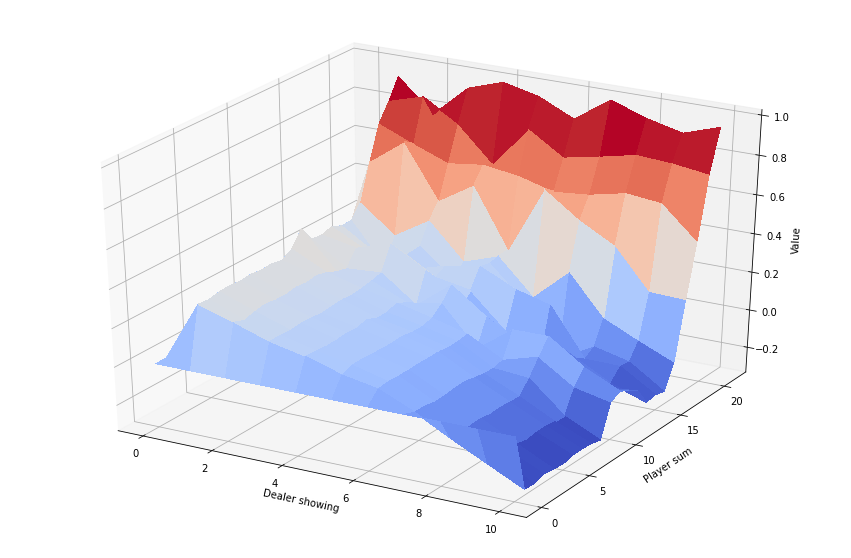

In [ ]:
plotValueFunction(epsilonGreedyAgent.q)

<class 'numpy.ndarray'>
11


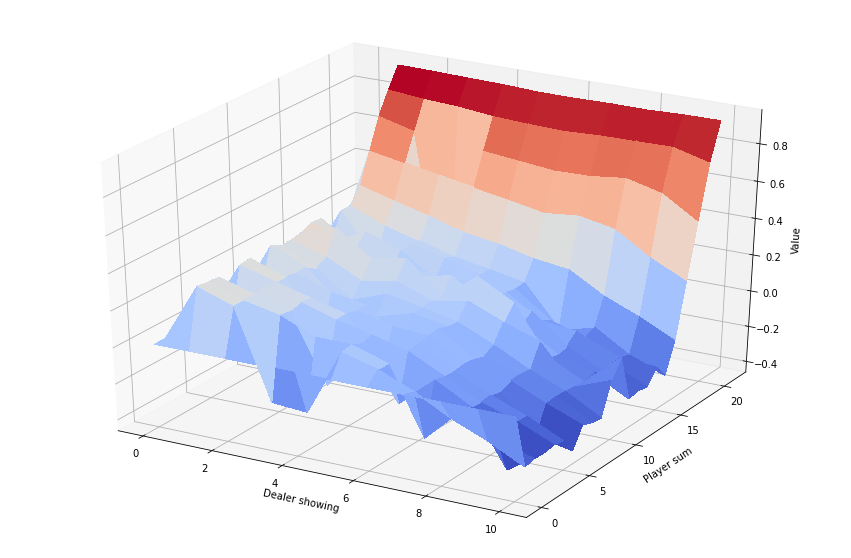

In [ ]:
plotValueFunction(exploringStartsAgent.q)

<class 'numpy.ndarray'>
11


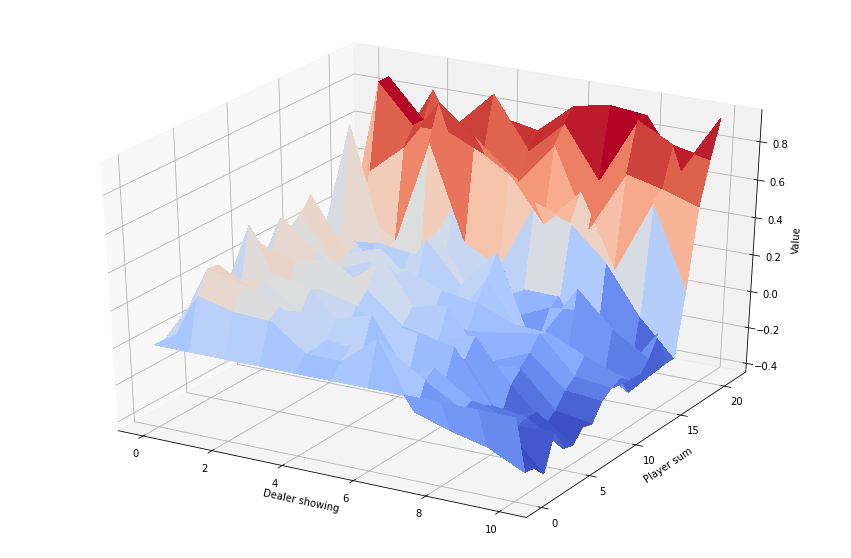

In [ ]:
plotValueFunction(tdAgent.q)